In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pdf = pd.read_csv("pull_requests.csv", parse_dates=['created_at', 'closed_at', 'merged_at'])

/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (77,99) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pdf.columns

Index(['url', 'id', 'node_id', 'html_url', 'diff_url', 'patch_url',
       'issue_url', 'number', 'state', 'locked',
       ...
       'assignee.received_events_url', 'assignee.type', 'assignee.site_admin',
       'head.repo', 'head.repo.license.key', 'head.repo.license.name',
       'head.repo.license.spdx_id', 'head.repo.license.url',
       'head.repo.license.node_id', 'head.user'],
      dtype='object', length=335)

https://developer.github.com/v3/pulls/#list-pull-requests
* "state": "open",
* "created_at": "2011-01-26T19:01:12Z",
* "closed_at": "2011-01-26T19:01:12Z",
* "merged_at": "2011-01-26T19:01:12Z",

In [4]:
psub = pdf[['user.login', 'id', 'state', 'created_at', 'closed_at', 'merged_at', 'author_association']].copy()

In [5]:
psub.drop(labels=7701, inplace=True) # negative close rate

In [6]:
psub.columns

Index(['user.login', 'id', 'state', 'created_at', 'closed_at', 'merged_at',
       'author_association'],
      dtype='object')

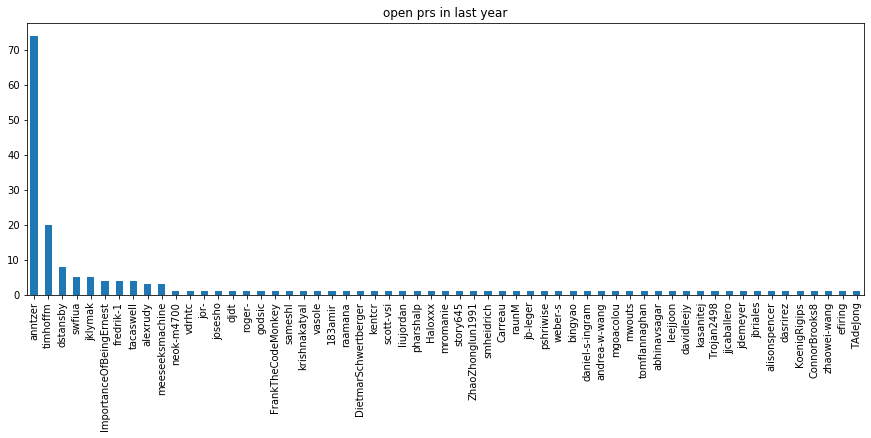

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("open prs in last year")
_ = psub[(psub['created_at']>'2018-07-17') & 
         psub['state'].str.match('open')]['user.login'].value_counts().plot.bar(ax=ax)

In [8]:
#drop bot
psub = psub[~psub['user.login'].str.match('meeseeksmachine')]

In [9]:
psub['merge_rate'] = psub['merged_at'] - psub['created_at']
psub['close_rate'] = psub['closed_at'] - psub['created_at']

In [10]:
# blank out the close without merging
psub['close_wno_merge_rate'] = psub['close_rate']
psub['close_wno_merge_rate'] = psub['close_rate'].where(psub['merge_rate'].isnull(), pd.NaT, )

In [11]:
psub[['merge_rate', 'close_rate', 'close_wno_merge_rate']].describe()

,merge_rate,close_rate,close_wno_merge_rate
count,6937,8233,1296
mean,15 days 22:07:28.792129,37 days 17:31:25.677274,154 days 11:04:33.095679
std,57 days 13:10:23.177546,140 days 23:25:45.074302,303 days 23:53:38.503900
min,0 days 00:00:05,0 days 00:00:05,0 days 00:00:05
25%,0 days 06:03:15,0 days 06:36:50,0 days 18:09:52
50%,1 days 06:11:17,1 days 15:39:59,11 days 19:26:05.500000
75%,7 days 07:29:37,10 days 20:12:11,143 days 01:31:16.500000
max,1172 days 02:46:16,2003 days 08:13:21,2003 days 08:13:21


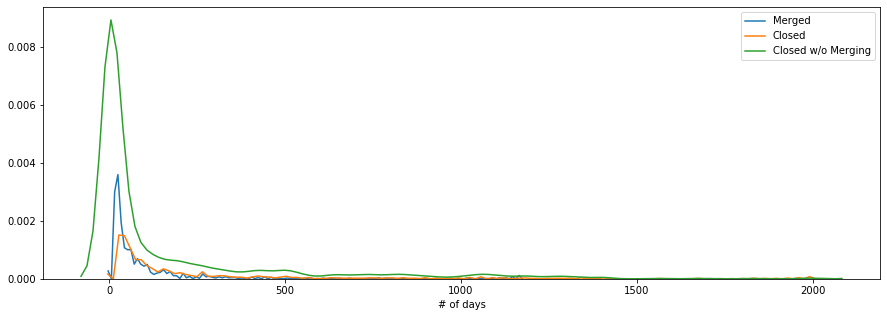

In [12]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,5))
_ = sns.distplot(psub['merge_rate'].dropna(how='all').dt.days, ax=ax, hist=False, label="Merged")
_ = sns.distplot(psub['close_rate'].dropna(how='all').dt.days, ax=ax, hist=False, label="Closed")
_ = sns.distplot(psub['close_wno_merge_rate'].dropna(how='all').dt.days, ax=ax, 
                 hist=False, label='Closed w/o Merging')
_ = ax.legend()
_ = ax.set_xlabel("# of days")

In [13]:
p2019 = psub[psub['created_at']>'2018-07-1'].copy()

In [14]:
ppr = p2019.groupby([pd.Grouper(key='created_at', freq='m'), 'state']).count()

/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


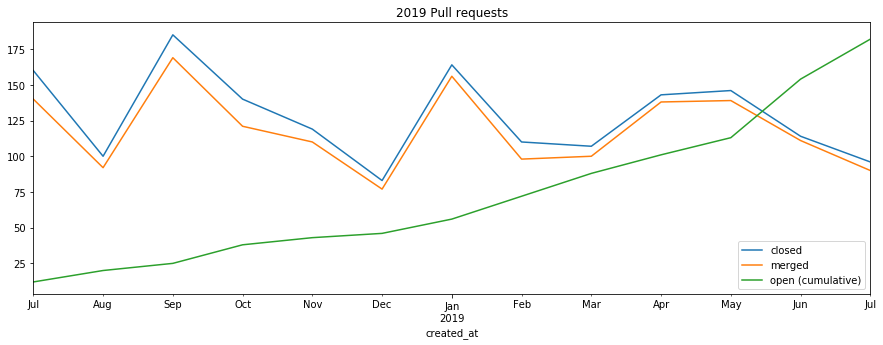

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.set_title("2019 Pull requests")
_ = ppr['closed_at'].unstack()['closed'].plot(ax=ax, label='closed')
_ = ppr['merged_at'].unstack()['closed'].plot(ax=ax, label='merged')
_ = ppr['user.login'].unstack()['open'].cumsum().plot(ax=ax, label='open (cumulative)') 
_ = ax.legend()

In [16]:
pre2019 = psub[(psub['created_at']<='2018-07-1') & psub['state'].str.match('open')]['state'].count()

In [17]:
opened = p2019.groupby(pd.Grouper(key='created_at', freq='M'))['created_at'].count()

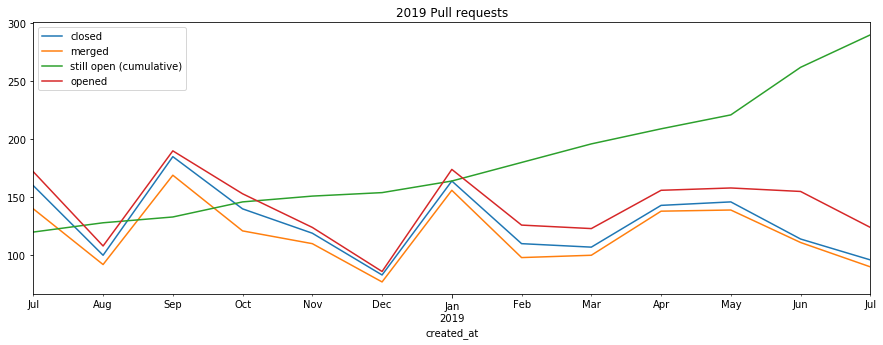

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.set_title("2019 Pull requests")
_ = ppr['closed_at'].unstack()['closed'].plot(ax=ax, label='closed')
_ = ppr['merged_at'].unstack()['closed'].plot(ax=ax, label='merged')
_ = (ppr['user.login'].unstack()['open'].cumsum() + pre2019).plot(ax=ax, label='still open (cumulative)')
_ = opened.plot(ax=ax, label='opened')
    
_ = ax.legend()

In [19]:
psub.columns

Index(['user.login', 'id', 'state', 'created_at', 'closed_at', 'merged_at',
       'author_association', 'merge_rate', 'close_rate',
       'close_wno_merge_rate'],
      dtype='object')

In [20]:
pdr = psub.groupby([pd.Grouper(key='created_at', freq='m'), 'state']).count()
all_opened = psub.groupby(pd.Grouper(key='created_at', freq='m'))['created_at'].count()

/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


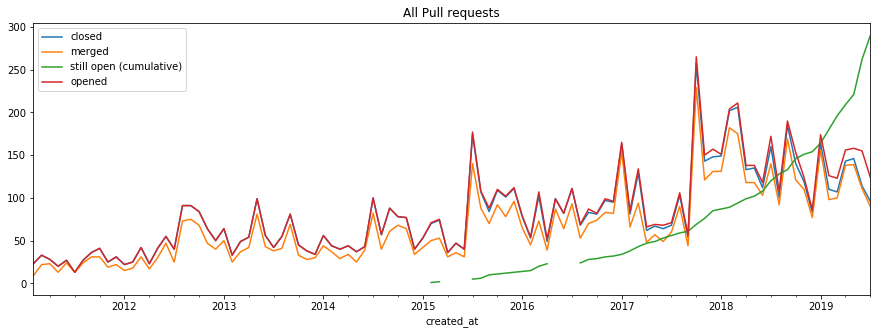

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.set_title("All Pull requests")
_ = pdr['closed_at'].unstack()['closed'].plot(ax=ax, label='closed')
_ = pdr['merged_at'].unstack()['closed'].plot(ax=ax, label='merged')
_ = pdr['user.login'].unstack()['open'].cumsum().plot(ax=ax, label='still open (cumulative)') 
_ = all_opened.plot(label = "opened")
_ = ax.legend()

In [22]:
pdf[pdf['user.login'].str.match('meeseeksmachine')][['created_at','closed_at', 'merged_at']].count()

created_at    526
closed_at     523
merged_at     515
dtype: int64

In [23]:
523/526, 515/526

(0.9942965779467681, 0.9790874524714829)

/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


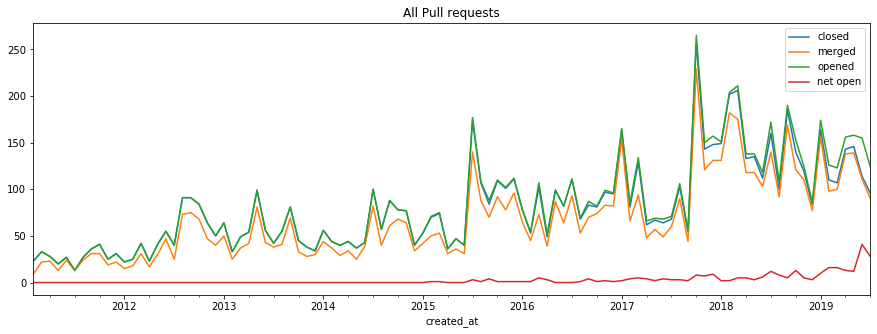

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
_ = ax.set_title("All Pull requests")
_ = pdr['closed_at'].unstack()['closed'].plot(ax=ax, label='closed')
_ = pdr['merged_at'].unstack()['closed'].plot(ax=ax, label='merged')
#_ = pdr['created_at'].unstack()['open'].cumsum().plot(ax=ax, label='still open (cumulative)') 
_ = all_opened.plot(label = "opened")
_ = (all_opened-pdr['closed_at'].unstack()['closed']).plot(ax=ax, label='net open')
_ = ax.set_label("# PRs")
_ = ax.legend()

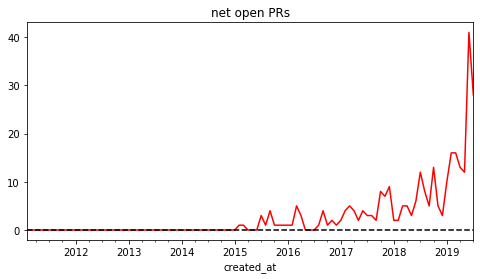

In [25]:
fig, ax = plt.subplots(figsize=(8,4))
_ = ax.set_title("net open PRs")
_ = (all_opened-pdr['closed_at'].unstack()['closed']).plot(ax=ax, label='net open', color='red')
_ = ax.axhline(y=0, color='black', linestyle='--')

# Anthony Effect

In [26]:
psub[psub['state'].str.match('open')]['user.login'].value_counts()['anntzer']

85

In [27]:
psub[psub['state'].str.match('open')]['user.login'].value_counts().sum()

290

In [28]:
85/290

0.29310344827586204

In [29]:
pna = psub[psub['user.login'].str.match('anntzer')]

In [30]:
pga = pna.groupby(pd.Grouper(key='created_at', freq='M')).count()

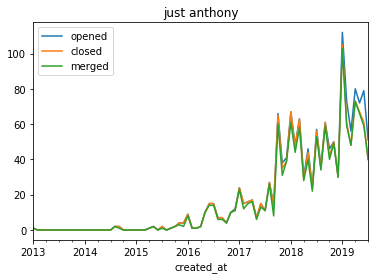

In [31]:
fig, ax = plt.subplots()
ax.set_title("just anthony")
pga[['user.login', 'closed_at', 'merged_at']].plot(ax=ax)
ax.legend(['opened', "closed", "merged"])

In [32]:
pnoa = psub[~psub['user.login'].str.match('anntzer')]
pnga = pnoa.groupby(pd.Grouper(key='created_at', freq='M')).count() 

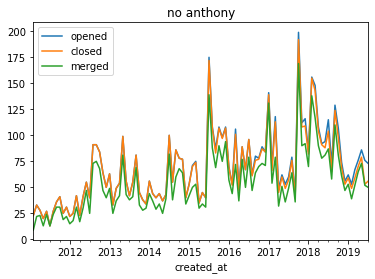

In [33]:
fig, ax = plt.subplots()
ax.set_title("no anthony")
pnga[['user.login', 'closed_at', 'merged_at']].plot(ax=ax)
ax.legend(['opened', "closed", "merged"])

In [34]:
pnga['user'] = 'everyone else'
pga['user'] = 'anthony'

In [35]:
pgg = pd.concat([pnga, pga])

In [36]:
# count anthony, everyone else
ant = pgg.reset_index().groupby([pd.Grouper(key='created_at', freq='m'),'user']).sum().unstack().fillna(0)

In [37]:
ant.head()

user.login                    id                \
user                         anthony everyone else anthony everyone else   
created_at                                                                 
2011-02-28 00:00:00+00:00        0.0          23.0     0.0          23.0   
2011-03-31 00:00:00+00:00        0.0          33.0     0.0          33.0   
2011-04-30 00:00:00+00:00        0.0          28.0     0.0          28.0   
2011-05-31 00:00:00+00:00        0.0          20.0     0.0          20.0   
2011-06-30 00:00:00+00:00        0.0          27.0     0.0          27.0   

                            state               closed_at                \
user                      anthony everyone else   anthony everyone else   
created_at                                                                
2011-02-28 00:00:00+00:00     0.0          23.0       0.0          23.0   
2011-03-31 00:00:00+00:00     0.0          33.0       0.0          33.0   
2011-04-30 00:00:00+00:00     0.0          28.0       0.0          28.0   
2011-05-31 00:00:00+00:00     0.0          20.0       0.0          20.0   
2011-06-30 00:00:00+00:00     0.0          27.0       0.0          27.0   

                          merged_at               author_association  \
user                        anthony everyone else            anthony   
created_at                                                             
2011-02-28 00:00:00+00:00       0.0           9.0                0.0   
2011-03-31 00:00:00+00:00       0.0          22.0                0.0   
2011-04-30 00:00:00+00:00       0.0          23.0                0.0   
2011-05-31 00:00:00+00:00       0.0          13.0                0.0   
2011-06-30 00:00:00+00:00       0.0          24.0                0.0   

                                        merge_rate               close_rate  \
user                      everyone else    anthony everyone else    anthony   
created_at                                                                    
2011-02-28 00:00:00+00:00          23.0        0.0           9.0        0.0   
2011-03-31 00:00:00+00:00          33.0        0.0          22.0        0.0   
2011-04-30 00:00:00+00:00          28.0        0.0          23.0        0.0   
2011-05-31 00:00:00+00:00          20.0        0.0          13.0        0.0   
2011-06-30 00:00:00+00:00          27.0        0.0          24.0        0.0   

                                        close_wno_merge_rate                
user                      everyone else              anthony everyone else  
created_at                                                                  
2011-02-28 00:00:00+00:00          23.0                  0.0          14.0  
2011-03-31 00:00:00+00:00          33.0                  0.0          11.0  
2011-04-30 00:00:00+00:00          28.0                  0.0           5.0  
2011-05-31 00:00:00+00:00          20.0                  0.0           7.0  
2011-06-30 00:00:00+00:00          27.0                  0.0           3.0

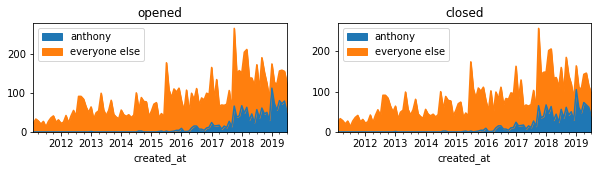

In [38]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,2))
_ = ax1.set_title("opened")
_ = ant['user.login'].plot.area(ax=ax1)
_ = ax1.legend()
_ = ax2.set_title("closed")
_ = ant['closed_at'].plot.area(ax=ax2)
_ = ax2.legend()

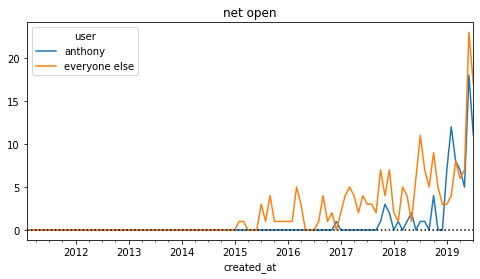

In [39]:
#group nets:
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title('net open')
_ = (ant['user.login']-ant['closed_at']).plot(ax=ax)
_ = ax.axhline(0, color='k', linestyle=":")

# contributor type

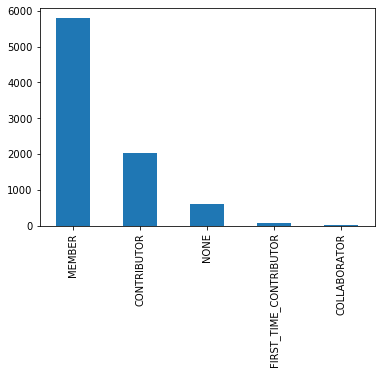

In [40]:
psub['author_association'].value_counts().plot.bar()

In [41]:
nobot = pdf[~pdf['user.login'].str.match('meeseeksmachine')]

In [42]:
psub.groupby('author_association')[['merge_rate','close_rate', 'close_wno_merge_rate']].describe().T

author_association                       COLLABORATOR  \
merge_rate           count                         19   
                     mean      6 days 18:32:14.263157   
                     std       6 days 23:39:46.248270   
                     min              0 days 00:03:47   
                     25%              1 days 21:37:18   
                     50%              3 days 17:28:02   
                     75%      12 days 02:51:05.500000   
                     max             20 days 12:01:03   
close_rate           count                         21   
                     mean    101 days 18:02:45.428571   
                     std     435 days 18:14:05.263673   
                     min              0 days 00:03:47   
                     25%              2 days 01:55:33   
                     50%              4 days 18:32:01   
                     75%             13 days 05:17:40   
                     max           2003 days 08:13:21   
close_wno_merge_rate count                          2   
                     mean          1004 days 01:22:41   
                     std    1413 days 04:51:49.959423   
                     min              4 days 18:32:01   
                     25%            504 days 09:57:21   
                     50%           1004 days 01:22:41   
                     75%           1503 days 16:48:01   
                     max           2003 days 08:13:21   

author_association                       CONTRIBUTOR  \
merge_rate           count                      1596   
                     mean    20 days 22:04:06.270676   
                     std     75 days 01:21:46.382544   
                     min             0 days 00:01:10   
                     25%      0 days 06:42:31.250000   
                     50%      1 days 17:27:29.500000   
                     75%             9 days 02:51:02   
                     max          1172 days 02:46:16   
close_rate           count                      1985   
                     mean    46 days 02:43:20.074559   
                     std    159 days 11:52:28.438642   
                     min             0 days 00:00:07   
                     25%             0 days 07:09:33   
                     50%             2 days 02:08:47   
                     75%            14 days 08:43:20   
                     max          1985 days 15:06:06   
close_wno_merge_rate count                       389   
                     mean   149 days 11:30:45.840616   
                     std    305 days 22:26:27.284078   
                     min             0 days 00:00:07   
                     25%             0 days 11:57:42   
                     50%             9 days 20:17:22   
                     75%           130 days 06:31:31   
                     max          1985 days 15:06:06   

author_association            FIRST_TIME_CONTRIBUTOR  \
merge_rate           count                         1   
                     mean            5 days 01:18:20   
                     std                         NaT   
                     min             5 days 01:18:20   
                     25%             5 days 01:18:20   
                     50%             5 days 01:18:20   
                     75%             5 days 01:18:20   
                     max             5 days 01:18:20   
close_rate           count                        16   
                     mean    73 days 21:02:59.187500   
                     std    204 days 22:55:42.594135   
                     min             0 days 00:00:28   
                     25%      0 days 03:55:27.500000   
                     50%             5 days 08:34:31   
                     75%     32 days 03:40:29.500000   
                     max           825 days 15:40:00   
close_wno_merge_rate count                        15   
                     mean    78 days 11:09:57.800000   
                     std    211 days 07:07:14.736282   
                     min             0 days 00:00:28 

In [43]:
import numpy as np
atype = psub[['author_association','merge_rate', 'close_rate', 'close_wno_merge_rate']].melt(id_vars='author_association',
     value_vars=['merge_rate', 'close_rate', 'close_wno_merge_rate'])
atype['days'] = atype['value'].dt.days
atype['log_days'] = np.log(atype['value'].dt.days)

/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [44]:
atype.head()

,author_association,variable,value,days,log_days
0,MEMBER,merge_rate,NaT,NaN,NaN
1,MEMBER,merge_rate,NaT,NaN,NaN
2,MEMBER,merge_rate,1 days 16:01:58,1.0,0.0
3,CONTRIBUTOR,merge_rate,0 days 05:20:50,0.0,-inf
4,MEMBER,merge_rate,NaT,NaN,NaN


# Distribution of days to close PRs by author type
Phobson suggested using the log since the distributions are so heavily skewed. 

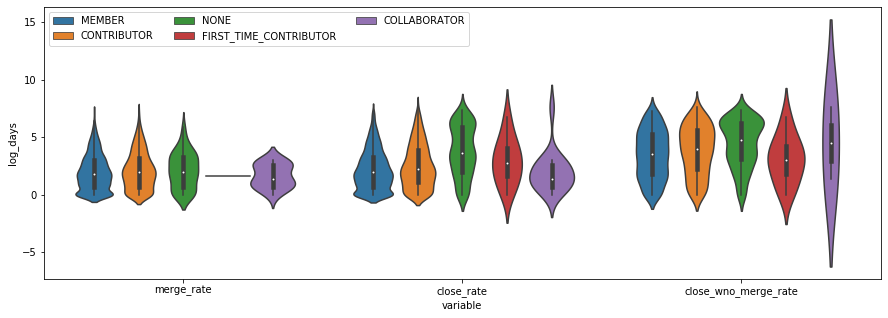

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
_ = sns.violinplot(x='variable', y ='log_days', hue='author_association', 
                   data=atype[np.isfinite(atype['log_days'])], ax=ax)
_ = ax.legend(ncol=3, loc='upper left')

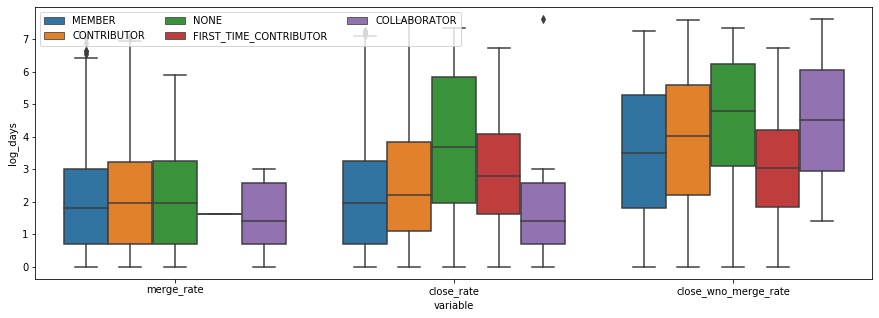

In [46]:
fig, ax = plt.subplots(figsize=(15,5))
_ = sns.boxplot(x='variable', y ='log_days', hue='author_association', 
                data=atype[np.isfinite(atype['log_days'])], ax=ax)
_ = ax.legend(ncol=3, loc='upper left')

/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/hannah/miniconda3/envs/mpl/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


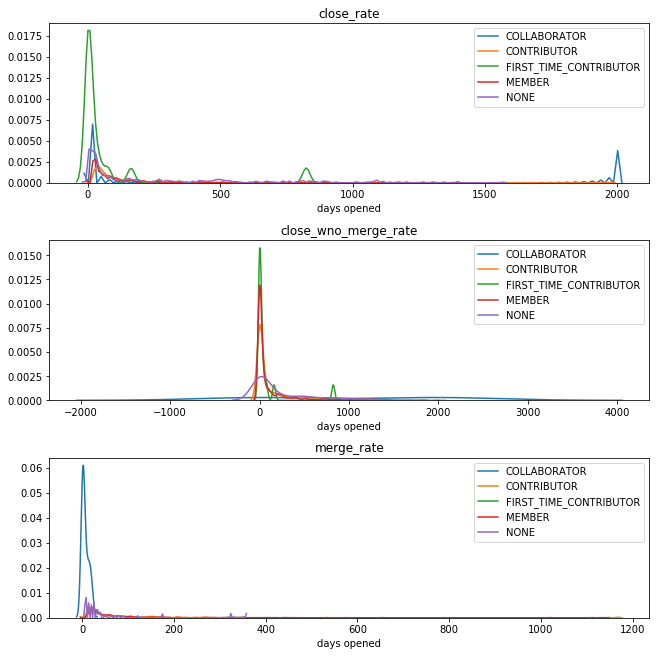

In [47]:
fig, axes = plt.subplots(nrows=3,figsize=(9,9), constrained_layout=True)
for ax, (var, dfg) in zip(axes, atype.groupby('variable')):
    ax.set_title(f'{var}')
    for group, dfga in dfg.groupby('author_association'):
        sns.distplot(dfga['days'], hist=False, label=group, ax=ax)
    ax.set_xlabel("days opened")  

In [48]:
import matplotlib.ticker as mticker
@mticker.FuncFormatter
def notlog(x, pos):
    if x <= 0:
        return 10**x
    else:
        return int(10**x)

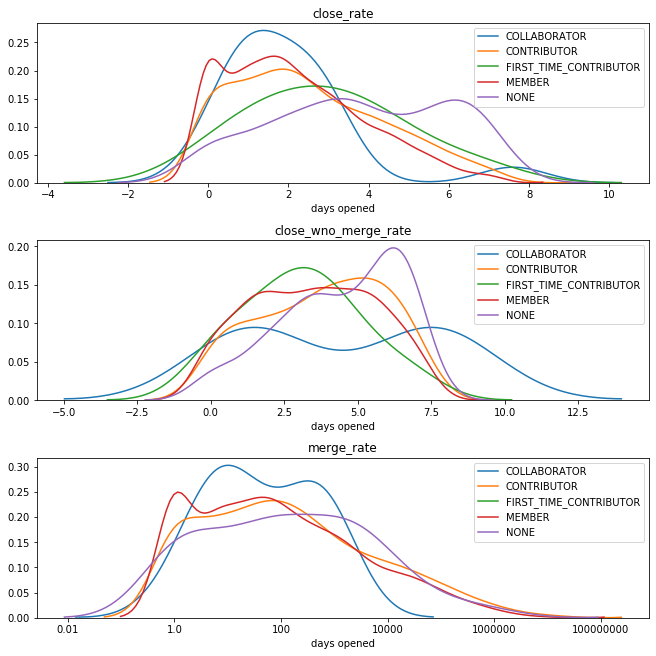

In [49]:
fig, axes = plt.subplots(nrows=3,figsize=(9,9), constrained_layout=True)
for ax, (var, dfg) in zip(axes, atype.groupby('variable')):
    ax.set_title(f'{var}')
    for group, dfga in dfg.groupby('author_association'):
        sns.distplot(dfga['log_days'], hist=False, label=group, ax=ax)
    ax.set_xlabel("days opened")
ax.xaxis.set_major_formatter(notlog)
    

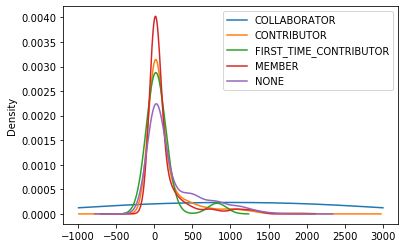

In [50]:
fig, ax = plt.subplots()
atype[atype['variable'].str.match('close_wno_merge_rate')].groupby('author_association')['days'].plot.kde(ax=ax)
ax.legend()

In [51]:
atype[atype['variable'].str.match('close_wno_merge_rate')].groupby('author_association')['days'].describe()

,count,mean,std,min,25%,50%,75%,max
author_association,,,,,,,,
COLLABORATOR,2.0,1003.500000,1413.506456,4.0,503.75,1003.5,1503.25,2003.0
CONTRIBUTOR,389.0,149.066838,305.899528,0.0,0.00,9.0,130.00,1985.0
FIRST_TIME_CONTRIBUTOR,15.0,78.133333,211.217852,0.0,0.00,5.0,36.00,825.0
MEMBER,622.0,122.943730,267.729732,0.0,0.00,8.0,92.75,1407.0
NONE,268.0,231.253731,348.715700,0.0,0.75,31.5,396.00,1562.0


Text(17.200000000000003, 0.5, 'Closed PRs (count)')

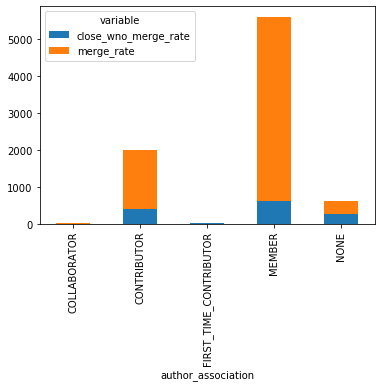

In [52]:
ag = atype.groupby(['author_association','variable']).count()['value'].unstack()
ag[['close_wno_merge_rate', 'merge_rate']].plot.bar(stacked='true')
ax.legend(["merged", "closed"])
ax.set_ylabel("Closed PRs (count)")

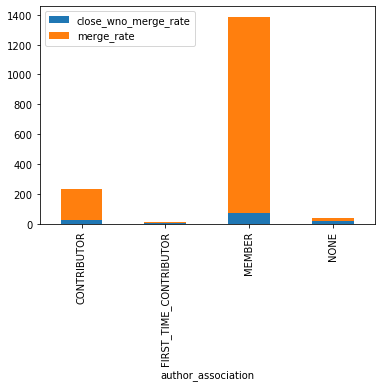

In [53]:
psub[psub['created_at']>'2018-07'].groupby('author_association').count()[['close_wno_merge_rate', 'merge_rate']].plot.bar(stacked='true')

In [54]:
psub.groupby(['author_association', pd.Grouper(key='created_at', freq='m')])['id', 'close_rate', 'close_wno_merge_rate'].count().unstack().T.describe()

author_association,COLLABORATOR,CONTRIBUTOR,FIRST_TIME_CONTRIBUTOR,MEMBER,NONE
count,18.000000,306.000000,93.000000,306.000000,282.000000
mean,2.444444,14.411765,1.161290,39.248366,5.248227
std,2.228749,11.950735,1.345607,38.534086,8.606177
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,5.000000,0.000000,8.250000,2.000000
50%,2.000000,13.000000,1.000000,25.000000,3.000000
75%,4.000000,20.000000,2.000000,63.000000,5.000000
max,7.000000,69.000000,6.000000,156.000000,67.000000


In [14]:
psub.groupby(['author_association', pd.Grouper(key='created_at', freq='m')])['id','closed_at', 'merged_at'].count().describe()

,id,closed_at,merged_at
count,335.000000,335.000000,335.000000
mean,25.441791,24.576119,20.707463
std,31.368517,30.153490,28.039073
min,1.000000,0.000000,0.000000
25%,4.000000,3.500000,1.000000
50%,15.000000,15.000000,11.000000
75%,30.000000,29.500000,25.000000
max,156.000000,148.000000,140.000000


In [15]:
psub[psub['created_at']>='2018-07-1'].groupby(['author_association', pd.Grouper(key='created_at', freq='m')])['id','closed_at', 'merged_at'].count().describe()

,id,closed_at,merged_at
count,50.000000,50.000000,50.00000
mean,36.980000,33.340000,30.82000
std,50.138376,46.751453,44.67419
min,1.000000,0.000000,0.00000
25%,3.000000,1.000000,0.00000
50%,11.000000,10.000000,9.00000
75%,57.250000,56.250000,52.75000
max,156.000000,148.000000,140.00000


In [18]:
psub[psub['created_at']>='2015'].groupby(['author_association', pd.Grouper(key='created_at', freq='m')])['id','closed_at'].count().describe()

,id,closed_at
count,194.000000,194.000000
mean,32.149485,30.654639
std,37.647304,36.154810
min,1.000000,0.000000
25%,4.000000,3.000000
50%,17.000000,17.000000
75%,44.000000,43.750000
max,156.000000,148.000000


In [58]:
pt = psub.groupby(['author_association', 'state']).count()['created_at'].unstack()
pt['cp'] = pt['closed']/pt.sum(axis=1)
pt['op'] = pt['open']/pt.sum(axis=1)

Text(0.5, 1.0, 'Pull Requests')

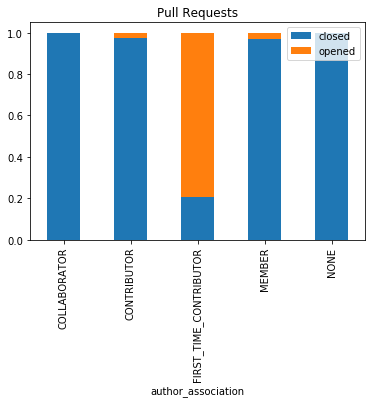

In [59]:
fig, ax = plt.subplots()
pt[['cp', 'op']].plot.bar(stacked=True, ax=ax)
ax.legend(["closed", 'opened'])
ax.set_title("Pull Requests")

In [62]:
psub['author_association'].unique()

array(['MEMBER', 'CONTRIBUTOR', 'FIRST_TIME_CONTRIBUTOR', 'NONE',
       'COLLABORATOR'], dtype=object)

In [69]:
ftopen = psub[psub['author_association'].str.match('FIRST_TIME_CONTRIBUTOR') & psub['state'].str.match('open')]

In [70]:
ftopen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 18 to 5664
Data columns (total 10 columns):
user.login              61 non-null object
id                      61 non-null int64
state                   61 non-null object
created_at              61 non-null datetime64[ns, UTC]
closed_at               0 non-null datetime64[ns, UTC]
merged_at               0 non-null datetime64[ns, UTC]
author_association      61 non-null object
merge_rate              0 non-null timedelta64[ns]
close_rate              0 non-null timedelta64[ns]
close_wno_merge_rate    0 non-null timedelta64[ns]
dtypes: datetime64[ns, UTC](3), int64(1), object(3), timedelta64[ns](3)
memory usage: 5.2+ KB


In [71]:
ftclosed = psub[psub['author_association'].str.match('FIRST_TIME_CONTRIBUTOR') & psub['state'].str.match('closed')]

In [74]:
ftclosed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 15 to 5607
Data columns (total 10 columns):
user.login              16 non-null object
id                      16 non-null int64
state                   16 non-null object
created_at              16 non-null datetime64[ns, UTC]
closed_at               16 non-null datetime64[ns, UTC]
merged_at               1 non-null datetime64[ns, UTC]
author_association      16 non-null object
merge_rate              1 non-null timedelta64[ns]
close_rate              16 non-null timedelta64[ns]
close_wno_merge_rate    15 non-null timedelta64[ns]
dtypes: datetime64[ns, UTC](3), int64(1), object(3), timedelta64[ns](3)
memory usage: 1.4+ KB


In [78]:
pfto = pdf[pdf['author_association'].str.match('FIRST_TIME_CONTRIBUTOR') & pdf['state'].str.match('open')]

In [80]:
pfto.to_csv("first_time_open.csv", index=False)

In [26]:
pgd = psub.groupby(pd.Grouper(key='created_at', freq='M')).count()

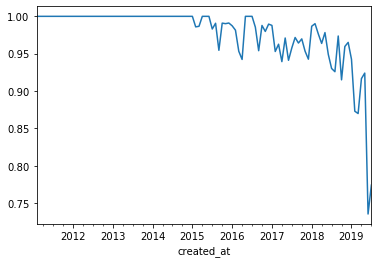

In [31]:
(pgd['close_rate']/pgd['id']).plot()

In [36]:
pgd['close_rate']/pgd['id']

created_at
2011-02-28 00:00:00+00:00    1.000000
2011-03-31 00:00:00+00:00    1.000000
2011-04-30 00:00:00+00:00    1.000000
2011-05-31 00:00:00+00:00    1.000000
2011-06-30 00:00:00+00:00    1.000000
                               ...   
2019-03-31 00:00:00+00:00    0.869919
2019-04-30 00:00:00+00:00    0.916667
2019-05-31 00:00:00+00:00    0.924051
2019-06-30 00:00:00+00:00    0.735484
2019-07-31 00:00:00+00:00    0.774194
Freq: M, Length: 102, dtype: float64

In [37]:
(73+77)/2

75.0

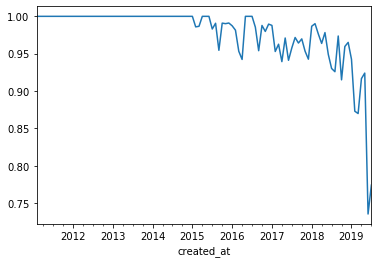

In [41]:
(pgd['close_rate']/pgd['id']).plot()

In [44]:
pdf['created_at'].count()

9050

In [45]:
pdf['closed_at'].count()

8757

In [57]:
pdf[(pdf['closed_at']>'2019-')]['closed_at'].isnull().sum()

0

In [62]:
pdf[['created_at', 'closed_at']][pdf[['created_at']>'2018['closed_at']

0                            NaT
1      2019-07-21 17:52:38+00:00
2                            NaT
3                            NaT
4      2019-07-21 14:06:15+00:00
                  ...           
9045   2011-02-20 20:31:10+00:00
9046   2011-02-23 07:13:41+00:00
9047   2011-02-21 01:48:32+00:00
9048   2011-02-22 12:46:23+00:00
9049   2011-05-24 23:45:23+00:00
Name: closed_at, Length: 9050, dtype: datetime64[ns, UTC]